# Plan and Execute Agent

https://github.com/kyopark2014/llm-agent/blob/main/planning-agents.md

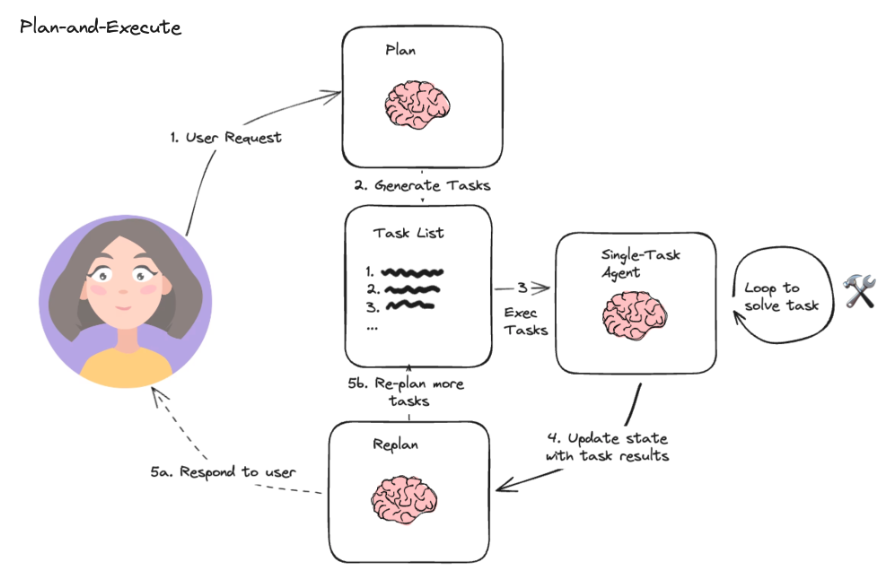

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [6]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [8]:
!pip install -U langchain-community tavily-python --quiet

In [9]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [10]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Plan-and-execute"

In [11]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="2023년 프로야구 우승팀은 누구인가요?"
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드릴 순 없지만, 현재 리그 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 가을 야구를 통해 최종 우승팀이 가려질 텐데, 그때까지 기다려 보는 게 좋겠네요. 지금까지의 성적과 전력으로 봤을 때 어떤 팀들이 유력할 것 같나요?

'안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드릴 순 없지만, 현재 리그 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 가을 야구를 통해 최종 우승팀이 가려질 텐데, 그때까지 기다려 보는 게 좋겠네요. 지금까지의 성적과 전력으로 봤을 때 어떤 팀들이 유력할 것 같나요?'

### Structed output example 1

In [12]:
from langchain_core.pydantic_v1 import BaseModel, Field

In [13]:
class AnswerWithJustification(BaseModel):
    '''An answer to the user question along with justification for the answer.'''
    answer: str
    justification: str
    
structured_llm = chat.with_structured_output(AnswerWithJustification, include_raw=True)

info = structured_llm.invoke("What weighs more a pound of bricks or a pound of feathers")
info

{'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 361, 'completion_tokens': 156, 'total_tokens': 517}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 361, 'completion_tokens': 156, 'total_tokens': 517}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-69ef95a3-190e-439e-ad81-edcf76b876a6-0', tool_calls=[{'name': 'AnswerWithJustification', 'args': {'answer': 'A pound of bricks and a pound of feathers weigh the same.', 'justification': 'A pound is a unit of weight or mass, not volume. Since a pound of bricks and a pound of feathers both have the same mass (one pound), they must weigh the same amount. The fact that bricks are denser and take up less volume than feathers for the same weight is irrelevant - their weights are equal when the mass is the same. This is a classic example that illustrates the difference between weight and density.'}

In [14]:
parsed_info = info['parsed']

print('answer: ', parsed_info.answer)
print('justification: ', parsed_info.justification)

answer:  A pound of bricks and a pound of feathers weigh the same.
justification:  A pound is a unit of weight or mass, not volume. Since a pound of bricks and a pound of feathers both have the same mass (one pound), they must weigh the same amount. The fact that bricks are denser and take up less volume than feathers for the same weight is irrelevant - their weights are equal when the mass is the same. This is a classic example that illustrates the difference between weight and density.


### Structed output example 2

In [15]:
class User(BaseModel):
    name: str
    age: int
    
structured_llm = chat.with_structured_output(User, include_raw=True)

info = structured_llm.invoke("Jason is 25 years old.")
info

{'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 322, 'completion_tokens': 50, 'total_tokens': 372}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 322, 'completion_tokens': 50, 'total_tokens': 372}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-c52fc1cf-8727-4674-9a5c-bcb67c46eee0-0', tool_calls=[{'name': 'User', 'args': {'name': 'Jason', 'age': 25}, 'id': 'toolu_bdrk_01LbrHTgLdC42cw2pV5MS6jo'}], usage_metadata={'input_tokens': 322, 'output_tokens': 50, 'total_tokens': 372}),
 'parsed': User(name='Jason', age=25),
 'parsing_error': None}

In [16]:
user_info = info['parsed']

print('name: ', user_info.name)
print('age: ', user_info.age)

name:  Jason
age:  25


## Structed output example 3

In [17]:
from typing import Annotated, List, Tuple, TypedDict

In [18]:
class Plan(BaseModel):
    """List of steps. The updated plan should be in the following format:
<plan>
[\"<step>\", \"<step>\", ...]
</plan>"""
    steps: List[str] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [19]:
structured_llm = chat.with_structured_output(Plan, include_raw=True)

In [20]:
info = structured_llm.invoke("To find the hometown of the 2024 Australian Open winner, we would need to follow these steps:\n\n1. Wait for the 2024 Australian Open tennis tournament to take place (typically in January 2024 in Melbourne, Australia).\n2. Identify the winner of the men's singles or women's singles tournament.\n3. Research biographical information about the 2024 Australian Open winner to determine their hometown or place of birth.\n4. The hometown or birthplace of the 2024 Australian Open winner is the final answer.\n\nSince the 2024 Australian Open has not happened yet, we cannot provide the actual hometown until the tournament takes place and the winner is determined. The key steps are to wait for the event, identify the winner, and then research their biographical details to find their hometown or birthplace.")
info

{'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 561, 'completion_tokens': 132, 'total_tokens': 693}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 561, 'completion_tokens': 132, 'total_tokens': 693}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-5c5bb98c-577f-406f-8c34-dab9ab38e3c1-0', tool_calls=[{'name': 'Plan', 'args': {'steps': ['Wait for the 2024 Australian Open tennis tournament to take place in January 2024.', "Identify the winner of the men's singles or women's singles tournament.", 'Research biographical information about the 2024 Australian Open winner.', 'Determine the hometown or place of birth of the winner from the biographical information.', "Response: The hometown of the 2024 Australian Open winner is [winner's hometown/birthplace]."]}, 'id': 'toolu_bdrk_01MELVwRoQLB8pnkzc7AoecH'}], usage_metadata={'input_tokens': 56

In [21]:
parsed_info = info['parsed']
parsed_info.steps

['Wait for the 2024 Australian Open tennis tournament to take place in January 2024.',
 "Identify the winner of the men's singles or women's singles tournament.",
 'Research biographical information about the 2024 Australian Open winner.',
 'Determine the hometown or place of birth of the winner from the biographical information.',
 "Response: The hometown of the 2024 Australian Open winner is [winner's hometown/birthplace]."]

## Define the State

In [22]:
import operator
from typing import Annotated, List, Tuple, TypedDict
from langgraph.graph.message import add_messages

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    #past_steps: Annotated[List, operator.add]
    messages: Annotated[list, add_messages]
    response: str

## Planning Step

In [23]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | chat

In [24]:
query = "what is the hometown of the 2023 Australia open winner?"

inputs = [HumanMessage(content=query)]

response = planner.invoke({"messages": inputs})
response.content

"To find the hometown of the 2023 Australian Open winner, we can follow these steps:\n\n1. Identify the winner of the 2023 Australian Open men's singles and women's singles tournaments.\n2. Search for biographical information on the winner(s) from reliable sources.\n3. From the biographical information, locate the place of birth or hometown of the winner(s).\n\nThe steps are:\n\n1. Identify the 2023 Australian Open winners.\n2. Search for their biographical information.\n3. Find their hometown/place of birth from the biographical information."

In [25]:
structured_llm = chat.with_structured_output(Plan, include_raw=True)

In [26]:
info = structured_llm.invoke(response.content)
info

{'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 511, 'completion_tokens': 64, 'total_tokens': 575}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 511, 'completion_tokens': 64, 'total_tokens': 575}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-03dfdaed-8067-497c-b05d-e015bb93f1d1-0', tool_calls=[{'name': 'Plan', 'args': {'steps': ['Identify the 2023 Australian Open winners', 'Search for their biographical information', 'Find their hometown/place of birth from the biographical information']}, 'id': 'toolu_bdrk_01CGko9wY7qJoxc3ojANhnzD'}], usage_metadata={'input_tokens': 511, 'output_tokens': 64, 'total_tokens': 575}),
 'parsed': Plan(steps=['Identify the 2023 Australian Open winners', 'Search for their biographical information', 'Find their hometown/place of birth from the biographical information']),
 'parsing_error': None}

In [27]:
if not info['parsed'] == None:
    parsed_info = info['parsed']
    print('parsed_info: ', parsed_info)
else:
    print('parsing_error: ', info['parsing_error'])

parsed_info:  steps=['Identify the 2023 Australian Open winners', 'Search for their biographical information', 'Find their hometown/place of birth from the biographical information']


## Create the Graph

In [28]:
class Plan(BaseModel):
    """List of steps. The updated plan should be in the following format:
[\"<step>\", \"<step>\", ...]"""
    steps: List[str] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [29]:
structured_llm = chat.with_structured_output(Plan, include_raw=True)

In [30]:
def plan_step(state: PlanExecute):
    print('input: ', state["input"])
    
    inputs = [HumanMessage(content=state["input"])]

    response = planner.invoke({"messages": inputs})
    print('response.content: ', response.content)
    
    info = structured_llm.invoke(response.content)
    print('info: ', info)
    
    if not info['parsed'] == None:
        parsed_info = info['parsed']
        print('parsed_info: ', parsed_info)
        
        print('steps: ', parsed_info.steps)
        
        return {
            "input": state['input'], 
            "plan": parsed_info.steps
        }
    else:
        print('parsing_error: ', info['parsing_error'])
        
        return {"plan": []}    

In [31]:
result = plan_step({"input": "what is the hometown of the 2023 Australia open winner?"})

input:  what is the hometown of the 2023 Australia open winner?
response.content:  To find the hometown of the 2023 Australian Open winner, we can follow these steps:

1. Identify the winner of the 2023 Australian Open men's singles and women's singles tournaments.
2. Search for biographical information on the winner(s) from reliable sources.
3. From the biographical information, locate the place of birth or hometown of the winner(s).

The steps are straightforward, but we'll need to wait until the 2023 Australian Open concludes to determine the winner(s) and then research their biographical details to find their hometown(s).
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 503, 'completion_tokens': 138, 'total_tokens': 641}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 503, 'completion_tokens': 138, 'total_tokens': 641}, 'stop_reason': 'tool_use', 'model_id': 'anthropi

In [32]:
result['plan']

["Identify the winner of the 2023 Australian Open men's singles tournament",
 "Identify the winner of the 2023 Australian Open women's singles tournament",
 "Search for biographical information on the men's singles winner from reliable sources",
 "Search for biographical information on the women's singles winner from reliable sources",
 "From the biographical information, locate the place of birth or hometown of the men's singles winner",
 "From the biographical information, locate the place of birth or hometown of the women's singles winner"]

In [33]:
def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    print("plan_str: ", plan_str)
    
    task = plan[0]
    task_formatted = f"""For the following plan:{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    print("task_formatted", task_formatted) 
    
    request = HumanMessage(
        content=task_formatted
    )
    
    agent_response = chain.invoke(
        {"messages": [request]}
    )
    print("agent_response: ", agent_response)
    
    return {
        #"past_steps": (task, agent_response["messages"][-1].content),
        "input": state['input'],
        "plan": plan,
        "past_steps": (task, agent_response.content),
    }

In [34]:
result

{'input': 'what is the hometown of the 2023 Australia open winner?',
 'plan': ["Identify the winner of the 2023 Australian Open men's singles tournament",
  "Identify the winner of the 2023 Australian Open women's singles tournament",
  "Search for biographical information on the men's singles winner from reliable sources",
  "Search for biographical information on the women's singles winner from reliable sources",
  "From the biographical information, locate the place of birth or hometown of the men's singles winner",
  "From the biographical information, locate the place of birth or hometown of the women's singles winner"]}

In [35]:
output = execute_step(result)

plan_str:  1. Identify the winner of the 2023 Australian Open men's singles tournament
2. Identify the winner of the 2023 Australian Open women's singles tournament
3. Search for biographical information on the men's singles winner from reliable sources
4. Search for biographical information on the women's singles winner from reliable sources
5. From the biographical information, locate the place of birth or hometown of the men's singles winner
6. From the biographical information, locate the place of birth or hometown of the women's singles winner
task_formatted For the following plan:1. Identify the winner of the 2023 Australian Open men's singles tournament
2. Identify the winner of the 2023 Australian Open women's singles tournament
3. Search for biographical information on the men's singles winner from reliable sources
4. Search for biographical information on the women's singles winner from reliable sources
5. From the biographical information, locate the place of birth or hometo

In [36]:
output

{'input': 'what is the hometown of the 2023 Australia open winner?',
 'plan': ["Identify the winner of the 2023 Australian Open men's singles tournament",
  "Identify the winner of the 2023 Australian Open women's singles tournament",
  "Search for biographical information on the men's singles winner from reliable sources",
  "Search for biographical information on the women's singles winner from reliable sources",
  "From the biographical information, locate the place of birth or hometown of the men's singles winner",
  "From the biographical information, locate the place of birth or hometown of the women's singles winner"],
 'past_steps': ("Identify the winner of the 2023 Australian Open men's singles tournament",
  '안녕하세요, 서연이에요. 2023 호주 오픈 테니스 대회 남자 단식 우승자를 알려드리겠습니다. \n\n2023년 1월에 열린 호주 오픈 테니스 대회에서 노바크 조코비치가 남자 단식 우승을 차지했습니다. 조코비치는 스테파노스 치치파스를 3-0(6-3, 7-6, 7-6)으로 꺾고 통산 22번째 메이저 대회 우승을 달성했습니다. 이로써 그는 라파엘 나달과 함께 메이저 대회 최다 우승 기록을 다시 한번 경신하게 되었습니다.')}

In [37]:
state = output
state

{'input': 'what is the hometown of the 2023 Australia open winner?',
 'plan': ["Identify the winner of the 2023 Australian Open men's singles tournament",
  "Identify the winner of the 2023 Australian Open women's singles tournament",
  "Search for biographical information on the men's singles winner from reliable sources",
  "Search for biographical information on the women's singles winner from reliable sources",
  "From the biographical information, locate the place of birth or hometown of the men's singles winner",
  "From the biographical information, locate the place of birth or hometown of the women's singles winner"],
 'past_steps': ("Identify the winner of the 2023 Australian Open men's singles tournament",
  '안녕하세요, 서연이에요. 2023 호주 오픈 테니스 대회 남자 단식 우승자를 알려드리겠습니다. \n\n2023년 1월에 열린 호주 오픈 테니스 대회에서 노바크 조코비치가 남자 단식 우승을 차지했습니다. 조코비치는 스테파노스 치치파스를 3-0(6-3, 7-6, 7-6)으로 꺾고 통산 22번째 메이저 대회 우승을 달성했습니다. 이로써 그는 라파엘 나달과 함께 메이저 대회 최다 우승 기록을 다시 한번 경신하게 되었습니다.')}

### Re-Plan Step

In [38]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

replanner = replanner_prompt | chat

In [39]:
output = replanner.invoke(state)
output

AIMessage(content='Based on the objective and the steps you have completed, the remaining steps in the plan would be:\n\n1. "Identify the winner of the 2023 Australian Open women\'s singles tournament"\n2. "Search for biographical information on the women\'s singles winner from reliable sources" \n3. "From the biographical information, locate the place of birth or hometown of the women\'s singles winner"\n\nWith these remaining steps, you should be able to determine the hometown of the 2023 Australian Open winner, whether it is the men\'s or women\'s singles champion.', additional_kwargs={'usage': {'prompt_tokens': 533, 'completion_tokens': 122, 'total_tokens': 655}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 533, 'completion_tokens': 122, 'total_tokens': 655}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-52bb1fa6-5c4a-44e2-a9bb-28a2358d49b1-0', usage_meta

In [40]:
output.content

'Based on the objective and the steps you have completed, the remaining steps in the plan would be:\n\n1. "Identify the winner of the 2023 Australian Open women\'s singles tournament"\n2. "Search for biographical information on the women\'s singles winner from reliable sources" \n3. "From the biographical information, locate the place of birth or hometown of the women\'s singles winner"\n\nWith these remaining steps, you should be able to determine the hometown of the 2023 Australian Open winner, whether it is the men\'s or women\'s singles champion.'

In [41]:
from typing import Union

class Response(BaseModel):
    """Response to user."""
    response: str
    
class Act(BaseModel):
    """Action to perform."""
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [42]:
structured_llm = chat.with_structured_output(Act, include_raw=True)

In [43]:
info = structured_llm.invoke(output.content)
info

{'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 623, 'completion_tokens': 88, 'total_tokens': 711}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 623, 'completion_tokens': 88, 'total_tokens': 711}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-a521b921-e49a-4676-95af-56ef862d76e5-0', tool_calls=[{'name': 'Act', 'args': {'action': {'steps': ["Identify the winner of the 2023 Australian Open women's singles tournament", "Search for biographical information on the women's singles winner from reliable sources", "From the biographical information, locate the place of birth or hometown of the women's singles winner"]}}, 'id': 'toolu_bdrk_01Cj7fyWSLhJwNqcrPPHfK22'}], usage_metadata={'input_tokens': 623, 'output_tokens': 88, 'total_tokens': 711}),
 'parsed': Act(action=Plan(steps=["Identify the winner of the 2023 Australian Open women's sing

In [44]:
result = info['parsed']
result

Act(action=Plan(steps=["Identify the winner of the 2023 Australian Open women's singles tournament", "Search for biographical information on the women's singles winner from reliable sources", "From the biographical information, locate the place of birth or hometown of the women's singles winner"]))

In [45]:
result.action

Plan(steps=["Identify the winner of the 2023 Australian Open women's singles tournament", "Search for biographical information on the women's singles winner from reliable sources", "From the biographical information, locate the place of birth or hometown of the women's singles winner"])

In [46]:
def replan_step(state: PlanExecute):
    output = replanner.invoke(state)
    
    structured_llm = chat.with_structured_output(Act, include_raw=True)
    info = structured_llm.invoke(output.content)
    
    result = info['parsed']
    
    if isinstance(result.action, Response):
        return {"response": result.action.response}
    else:
        return {"plan": result.action.steps}

In [47]:
replan_step(state)

{'plan': ["Identify the winner of the 2023 Australian Open women's singles tournament",
  "Search for biographical information on the women's singles winner from reliable sources",
  "From the biographical information, locate the place of birth or hometown of the women's singles winner"]}

# Plan and Execute

In [48]:
class Plan(BaseModel):
    """List of steps. The updated plan should be a list format.
[\"<step>\", \"<step>\", ...]
"""
    steps: List[str] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )
structured_llm = chat.with_structured_output(Plan, include_raw=True)

In [49]:
#<plan>
#[\"<step>\", \"<step>\", ...]
#</plan>"""

In [50]:
import operator
from typing import Annotated, List, Tuple, TypedDict
from langgraph.graph.message import add_messages

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    # past_steps: Annotated[List[Tuple], operator.add]
    #past_steps: Annotated[list[tuple[Response, Plan]], add_messages]
    past_steps: Annotated[List[Tuple], operator.add]
    #past_steps: Annotated[list, add_messages]
    response: str

### Planner

In [51]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | chat

In [52]:
def plan_step(state: PlanExecute):
    print('#### plan_step ####')
    print('input: ', state["input"])
    
    inputs = [HumanMessage(content=state["input"])]

    response = planner.invoke({"messages": inputs})
    print('response.content: ', response.content)
    
    info = structured_llm.invoke(response.content)
    print('info: ', info)
    
    if not info['parsed'] == None:
        parsed_info = info['parsed']
        #print('parsed_info: ', parsed_info)
        
        print('steps: ', parsed_info.steps)
        
        return {
            "input": state["input"],
            "plan": parsed_info.steps
        }
    else:
        print('parsing_error: ', info['parsing_error'])
        
        return {"plan": []}    

### Agent Executer

In [53]:
def execute_step(state: PlanExecute):
    print('#### execute_step ####')
    
    #input = state["input"]
    #print('input: ', input)
    
    plan = state["plan"]
    print('plan: ', plan) 
    
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    #print("plan_str: ", plan_str)
    
    task = plan[0]
    task_formatted = f"""For the following plan:{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    #print("task_formatted", task_formatted) 
    
    request = HumanMessage(content=task_formatted)
    
    agent_response = chain.invoke({"messages": [request]})
    print("agent_response: ", agent_response)
    
    print('task: ', task)
    print('agent_response.content: ', agent_response.content)
    
    return {
        "input": state["input"],
        "plan": state["plan"],
        #"past_steps": (task, agent_response["messages"][-1].content),
        "past_steps": (task, agent_response.content),
        #"past_steps": task,
    }

### Re-plan

In [54]:
from typing import Union

class Response(BaseModel):
    """Response to user."""
    response: str
    
class Act(BaseModel):
    """Action to perform."""
    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )

In [55]:
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)

replanner = replanner_prompt | chat

In [56]:
def replan_step(state: PlanExecute):
    print('#### replan_step ####')
    output = replanner.invoke(state)
    print('output.content: ', output)
    
    structured_llm = chat.with_structured_output(Act, include_raw=True)
    
    info = structured_llm.invoke(output.content)
    print('info: ', info)
    
    result = info['parsed']
    print('result: ', result)
    
    if isinstance(result.action, Response):
        return {"response": result.action.response}
    else:
        return {"plan": result.action.steps}

In [322]:
state = {'input': '2023년 한국 프로야구 우승팀의 연고지는?', 'plan': ['1. 2023년 한국 프로야구 정규시즌 일정과 결과를 확인합니다.', '2. 정규시즌 최종 순위를 확인하여 한국시리즈 진출팀을 파악합니다.', '3. 한국시리즈 일정과 결과를 확인합니다.', '4. 한국시리즈 우승팀을 확인합니다.', '5. 우승팀의 연고지를 확인하여 최종 답변을 도출합니다.'], 'past_steps': ('1. 2023년 한국 프로야구 정규시즌 일정과 결과를 확인합니다.', '안녕하세요 서연입니다. 2023년 한국 프로야구 정규시즌 일정과 결과를 확인하는 것에 대해 설명드리겠습니다.\n\n2023년 프로야구 정규시즌은 4월 1일에 개막하여 10월 초까지 진행될 예정입니다. 10개 구단이 총 720경기를 치르게 됩니다. 정규시즌 일정은 KBO 공식 홈페이지나 각 구단 홈페이지에서 확인할 수 있습니다.\n\n정규시즌 경기 결과 역시 KBO 홈페이지나 포털사이트 스포츠 뉴스 등에서 실시간으로 확인할 수 있습니다. 매일 진행되는 경기 결과와 팀 순위, 선수 기록 등의 정보를 제공하고 있습니다.\n\n하지만 아직 2023시즌이 시작되지 않아 구체적인 일정과 결과를 확인할 수는 없습니다. 시즌이 진행되면 위에서 말씀드린 방법으로 정규시즌 일정과 결과를 확인할 수 있겠습니다.')}

In [236]:
replan_step(state)

#### replan_step ####
replan output:  content='2. 정규시즌 최종 순위를 확인하여 한국시리즈 진출팀을 파악합니다.\n3. 한국시리즈 일정과 결과를 확인합니다. \n4. 한국시리즈 우승팀을 확인합니다.\n5. 우승팀의 연고지를 확인하여 최종 답변을 도출합니다.' additional_kwargs={'usage': {'prompt_tokens': 778, 'completion_tokens': 126, 'total_tokens': 904}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 778, 'completion_tokens': 126, 'total_tokens': 904}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-c61f9497-5522-4bbb-a35a-01296ad867c0-0' usage_metadata={'input_tokens': 778, 'output_tokens': 126, 'total_tokens': 904}
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 610, 'completion_tokens': 165, 'total_tokens': 775}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 610, 'completion_tokens': 165, 'total_tokens': 775}, 'stop_reason': 'tool_use'

{'plan': ['1. 정규시즌 최종 순위를 확인하여 한국시리즈 진출팀을 파악합니다.',
  '2. 한국시리즈 일정과 결과를 확인합니다.',
  '3. 한국시리즈 우승팀을 확인합니다.',
  '4. 우승팀의 연고지를 확인하여 최종 답변을 도출합니다.']}

In [202]:
result

Act(action=Plan(steps=['Search for biographical information on Novak Djokovic to find his hometown or place of birth', "Note down the hometown for the men's singles winner", "Identify the 2023 Australian Open women's singles winner", "Search for biographical information on the women's singles winner to find her hometown or place of birth", "Note down the hometown for the women's singles winner"]))

In [203]:
result.action

Plan(steps=['Search for biographical information on Novak Djokovic to find his hometown or place of birth', "Note down the hometown for the men's singles winner", "Identify the 2023 Australian Open women's singles winner", "Search for biographical information on the women's singles winner to find her hometown or place of birth", "Note down the hometown for the women's singles winner"])

In [204]:
result.action.steps

['Search for biographical information on Novak Djokovic to find his hometown or place of birth',
 "Note down the hometown for the men's singles winner",
 "Identify the 2023 Australian Open women's singles winner",
 "Search for biographical information on the women's singles winner to find her hometown or place of birth",
 "Note down the hometown for the women's singles winner"]

In [184]:
Response

__main__.Response

### Shoud_end

In [57]:
from typing import Literal

def should_end(state: PlanExecute) -> Literal["continue", "end"]:
    print('#### should_end ####')
    print('state: ', state)
    if "response" in state and state["response"]:
        return "end"
    else:
        return "continue"

In [58]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(PlanExecute)
workflow.add_node("planner", plan_step)
workflow.add_node("agent", execute_step)
workflow.add_node("replan", replan_step)
#workflow.add_edge(START, "planner")
workflow.set_entry_point("planner")
workflow.add_edge("planner", "agent")
workflow.add_edge("agent", "replan")
workflow.add_conditional_edges(
    "replan",
    should_end,
    {
        "continue": "agent",
        "end": END,
    },
)

app = workflow.compile()

### Run

In [59]:
inputs = {"input": "2023년 한국 프로야구 우승팀의 연고지는?"}
config = {"recursion_limit": 50}
for event in app.stream(inputs, config=config):
    print('event: ', event)
    #for k, v in event.items():
    #    if k != END:
    #        print(v)

#### plan_step ####
input:  2023년 한국 프로야구 우승팀의 연고지는?
response.content:  2023년 한국 프로야구 우승팀의 연고지를 알아내기 위한 단계별 계획은 다음과 같습니다:

1. 2023년 한국 프로야구 정규시즌 일정과 결과를 확인합니다.
2. 정규시즌 최종 순위를 확인하여 한국시리즈 진출팀을 파악합니다.
3. 한국시리즈 일정과 결과를 확인합니다. 
4. 한국시리즈 우승팀을 확인합니다.
5. 우승팀의 연고지를 확인하여 최종 답변을 도출합니다.

이 계획을 차근차근 따라가면 2023년 한국 프로야구 우승팀의 연고지를 정확히 알 수 있습니다.
info:  {'raw': AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 638, 'completion_tokens': 199, 'total_tokens': 837}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 638, 'completion_tokens': 199, 'total_tokens': 837}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-fefd0ce8-d111-4abd-a65b-39474a4000e0-0', tool_calls=[{'name': 'Plan', 'args': {'steps': ['1. 2023년 한국 프로야구 정규시즌 일정과 결과를 확인합니다.', '2. 정규시즌 최종 순위를 확인하여 한국시리즈 진출팀을 파악합니다.', '3. 한국시리즈 일정과 결과를 확인합니다.', '4. 한국시리즈 우승팀을 확인합니다.', '5. 우승팀의 연고지를 확인하여 최종 답변을 도출합니다.']}, 'i

TypeError: can only concatenate list (not "tuple") to list

In [ ]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the 2023 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)